### Trying Pyro on NHANES on a very simple case
 Case of one country with 3 age groups, no time include

In [4]:
import os
from collections import defaultdict
import torch
import numpy as np
import pandas as pd
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')


In [28]:
df = pd.read_csv('/Users/victorlhoste/Desktop/Local_PhD/NHANES/Data/data_pyro.csv', index_col=0)
df.head()

,height,bmi,WHtR,hba1c,hdl,non_hdl,sbp,dbp,eGFR,age_group
1,178.8,25.524376,0.496644,5.3,0.9842,5.9570,117,59,95.625163,20-40
2,162.2,23.433188,0.557953,4.6,1.4245,2.7195,130,88,114.670330,20-40
3,156.9,27.642813,0.570427,5.3,1.7094,4.4030,134,75,87.324169,40-60
4,177.4,29.392363,0.576099,4.6,1.1137,4.7138,135,94,77.957926,20-40
5,168.2,24.954721,0.558859,9.1,1.3209,5.4131,121,69,79.104629,40-60


In [92]:
## first try with a simple multinomial mixture on just height and BMI
df=df[["height"]]
df.head()
df.values

array([[178.8],
       [162.2],
       [156.9],
       ...,
       [164.9],
       [162.6],
       [175.8]])

In [93]:
data=torch.tensor(df.values.flatten())
data=data.float() # necessary for the code to run
#data = torch.tensor([0., 1., 10., 11., 12.])
data

tensor([178.8000, 162.2000, 156.9000,  ..., 164.9000, 162.6000, 175.8000])

In [94]:
K = 4  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

In [82]:
# Cell is just for debugging
# global_guide, optim, loss=elbo)

In [95]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [96]:
def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "scale":
        return (data.var() / 2).sqrt()
    if site["name"] == "locs":
        return data[torch.multinomial(torch.ones(len(data)) / len(data), K)]
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']),
                             init_loc_fn=init_loc_fn)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 24, initial_loss = 219763.8125


In [97]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(400 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

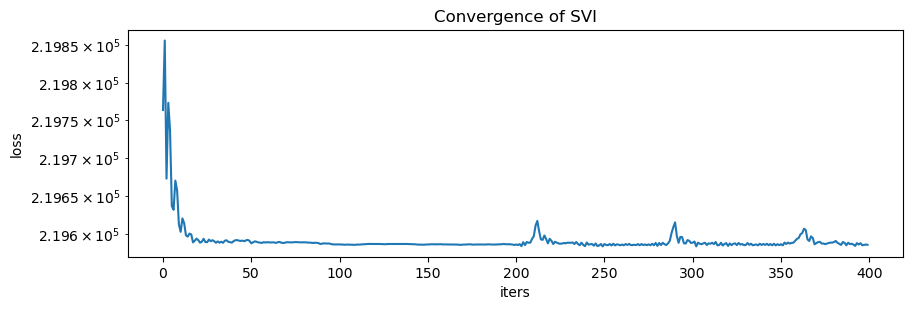

In [98]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

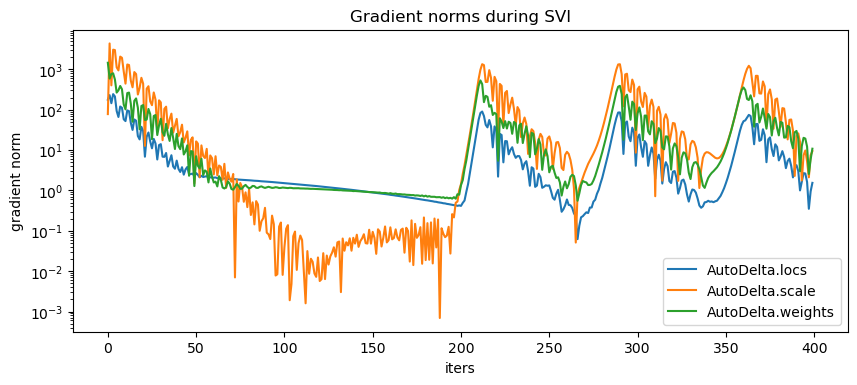

In [99]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [100]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.28499213 0.28438357 0.26362866 0.16699558]
locs = [176.93169 168.25066 159.85153 159.48698]
scale = 7.042628288269043


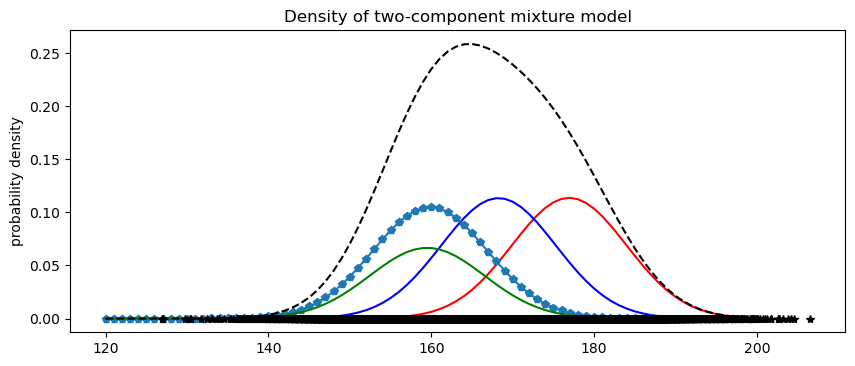

In [106]:
X = np.arange(120,200,1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())
Y3 = weights[2].item() * scipy.stats.norm.pdf((X - locs[2].item()) / scale.item())
Y4 = weights[3].item() * scipy.stats.norm.pdf((X - locs[3].item()) / scale.item())
pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(X, Y3, 'p-')
pyplot.plot(X, Y4, 'g-')
pyplot.plot(X, Y1 + Y2 + Y3 + Y4, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Density of two-component mixture model')
pyplot.ylabel('probability density');